In [35]:
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
from rosbags.rosbag2 import Reader
from rosbags.serde import deserialize_cdr
from rosbags.highlevel import AnyReader

import numpy as np

In [36]:

def analyze_data(bag_path, topic_name):
    poses_data = {
        'timestamp': [],
        'time_sec': [],
        'position': {
            'x': [],
            'y': [],
            'z': []
        },
        'orientation': {
            'x': [],
            'y': [],
            'z': [],
            'w': []
        },
        'covariance': []
    }
        
    with AnyReader([bag_path]) as reader:
        # Print bag info
        print(f"Bag duration: {reader.duration / 1e9:.2f} seconds")
        print(f"Message count: {reader.message_count}")

        connection = [x for x in reader.connections if x.topic == topic_name]
        
        # Read messages
        for connection, timestamp, rawdata in reader.messages(connections=connection):
            msg = reader.deserialize(rawdata, connection.msgtype)
            
            # Extract pose data
            poses_data['timestamp'].append(timestamp)
            poses_data['time_sec'].append(timestamp / 1e9)

            poses_data['position']['x'].append(msg.pose.pose.position.x)
            poses_data['position']['y'].append(msg.pose.pose.position.y)
            poses_data['position']['z'].append(msg.pose.pose.position.z)
            
            poses_data['orientation']['x'].append(msg.pose.pose.orientation.x)
            poses_data['orientation']['y'].append(msg.pose.pose.orientation.y)
            poses_data['orientation']['z'].append(msg.pose.pose.orientation.z)
            poses_data['orientation']['w'].append(msg.pose.pose.orientation.w)
            
            poses_data['covariance'].append(msg.pose.covariance)

    poses_data['covariance'] = np.array(poses_data['covariance'])
    # print(f"Read {len(poses_data)} pose messages")
    return poses_data


def plot_position_over_time(poses_data):
    plt.plot(
        poses_data['time_sec'],
        poses_data['position']['x']
    )
    plt.grid(True)
    plt.xlabel('t')
    plt.ylabel('x')
    plt.title('x position over time')
    plt.show()


def plot_trajectory(poses_data):
    plt.plot(
        poses_data['position']['x'],
        poses_data['position']['y']
    )
    plt.grid(True)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Trajectory over time')
    plt.show()
    

def plot_covariance(ax, poses_data, data_axis, title):
    ax.plot(
        poses_data['time_sec'],
        poses_data['covariance'][:, data_axis]
    )
    ax.set_title(title)
    ax.grid(True)
    ax.set_xlabel('t')
    ax.set_ylabel('Covariance')


def plot_covariances(poses_data):
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))

    plot_covariance(axes[0, 0], poses_data, 0, 'x')
    plot_covariance(axes[0, 1], poses_data, 7, 'y')
    plot_covariance(axes[0, 2], poses_data, 14, 'z')
    plot_covariance(axes[1, 0], poses_data, 21, 'roll')
    plot_covariance(axes[1, 1], poses_data, 28, 'pitch')
    plot_covariance(axes[1, 2], poses_data, 35, 'yaw')

    plt.show()

# Experiments with Monica (no IMU)

Bag duration: 93.10 seconds
Message count: 2824


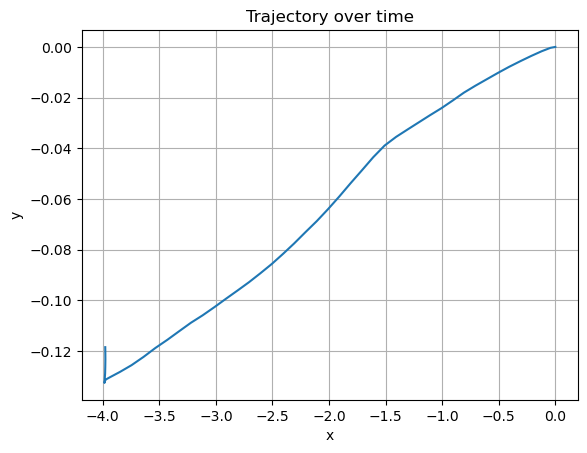

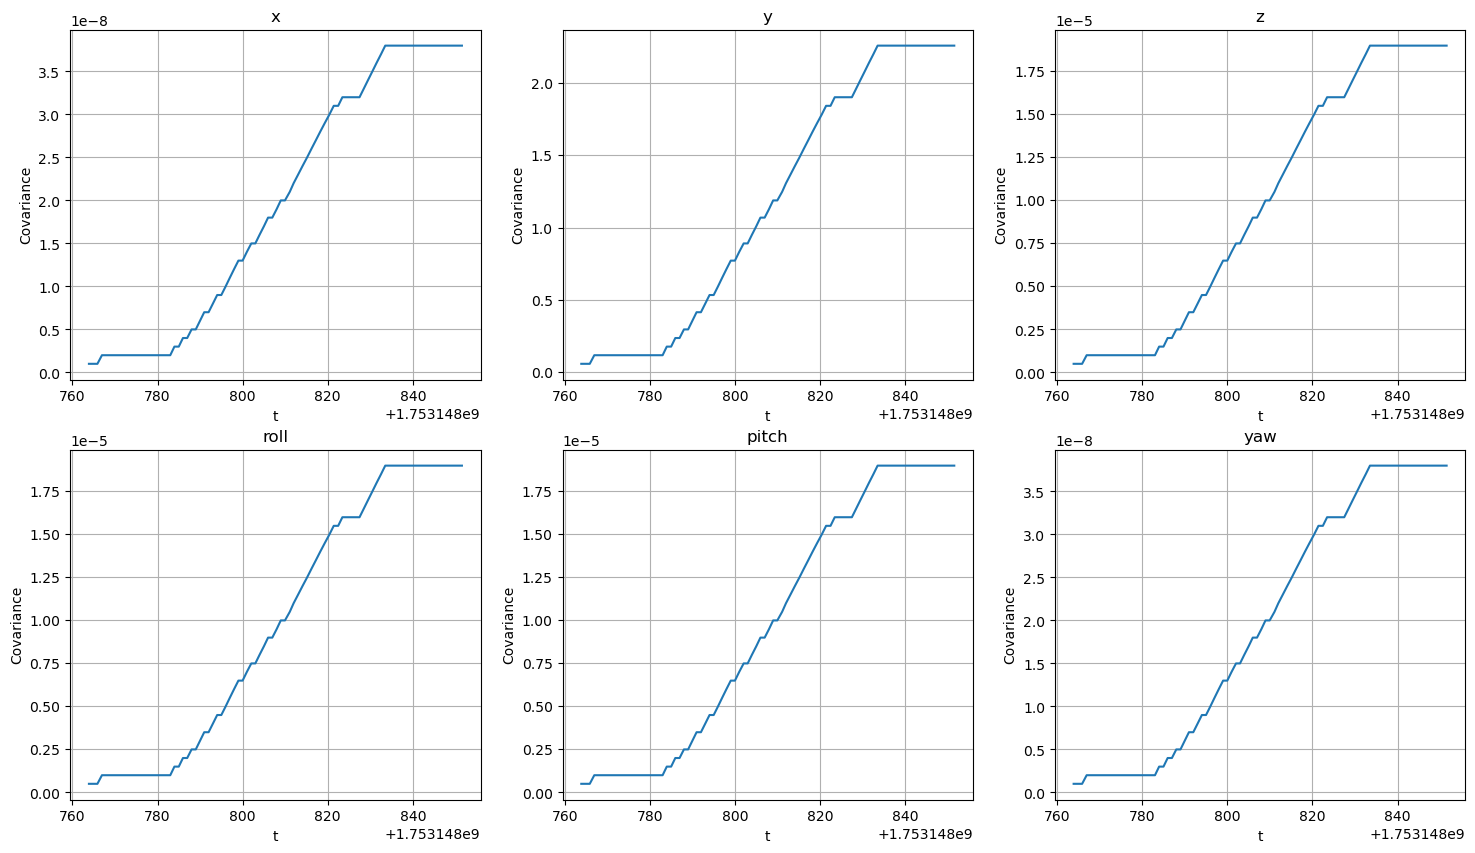

In [37]:
"""
Camera -> RTAB
Wheel odom -> EKF -> RTAB
"""

# RTAB Data
# with IMU
bag_path = Path('../../../datasets/odometry_data/monica_rtab_ekf_no_imu2')

poses_data = analyze_data(bag_path, '/monica/localization_pose')

plot_trajectory(poses_data)

plot_covariances(poses_data)

Bag duration: 93.10 seconds
Message count: 2824


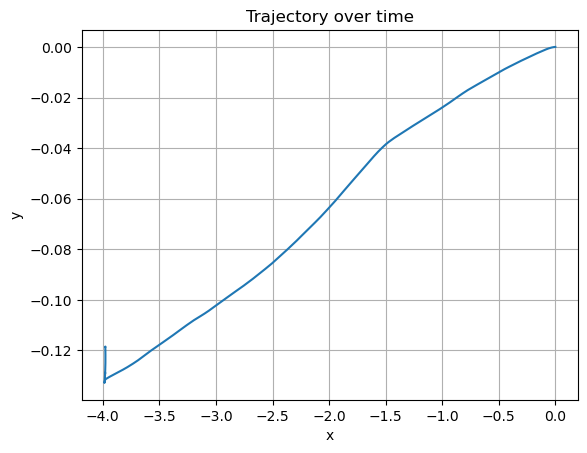

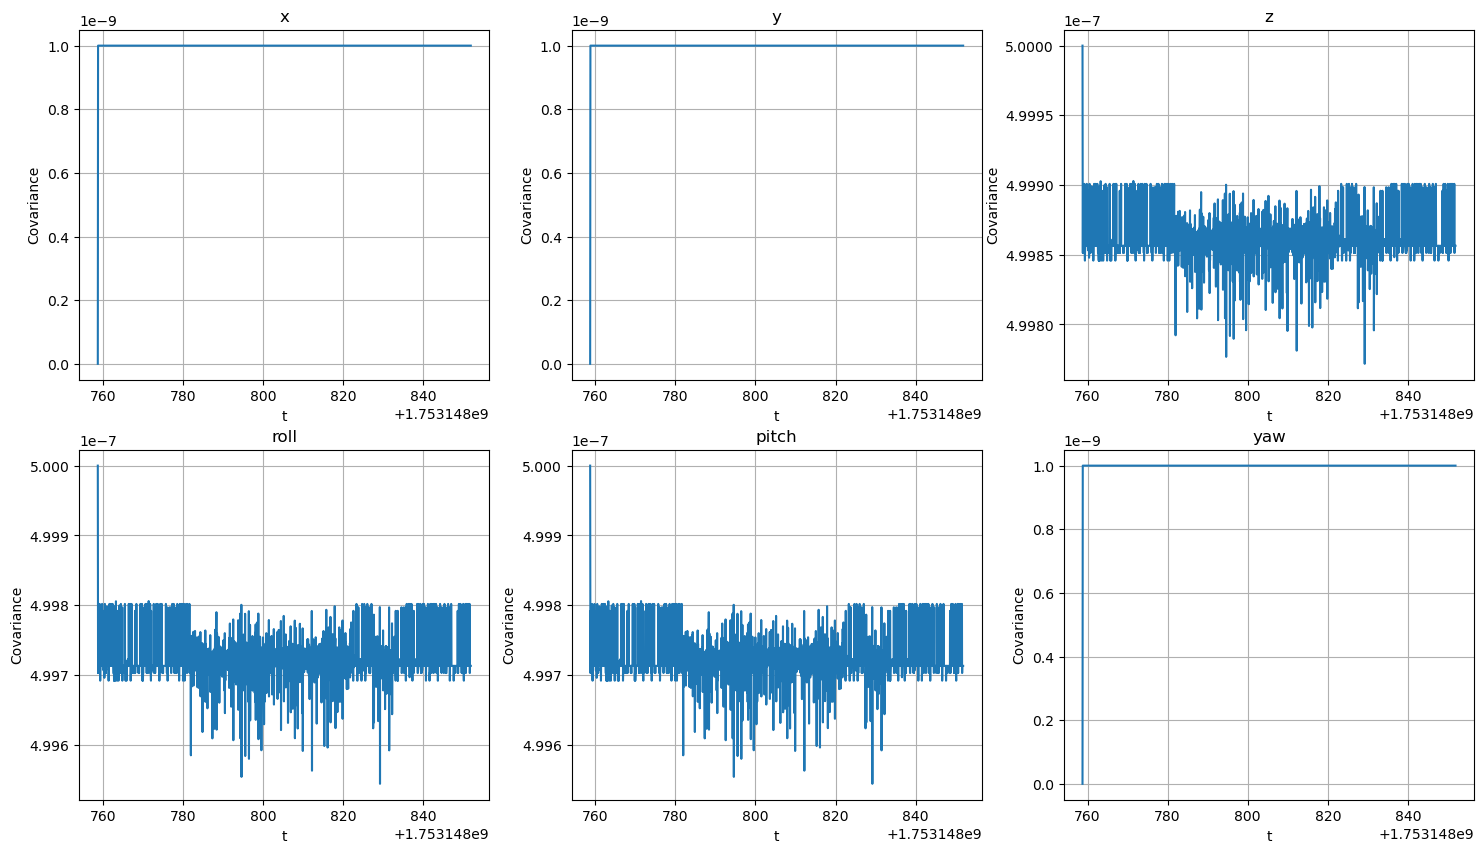

In [38]:
# EKF odometry output
ekf_data = analyze_data(bag_path, '/monica/odometry/filtered')

plot_trajectory(ekf_data)

plot_covariances(ekf_data)

# Experiments with Monica (only RTAB has IMU data)

## Notes
- For monica_rtab_with_imu_ekf_no_imu2, it seems RTAB and the EKF thought the robot was drifting in the other direction (-y vs. +y). This indicates something is wrong with the wheel odometry?
- 

Bag duration: 192.17 seconds
Message count: 5801


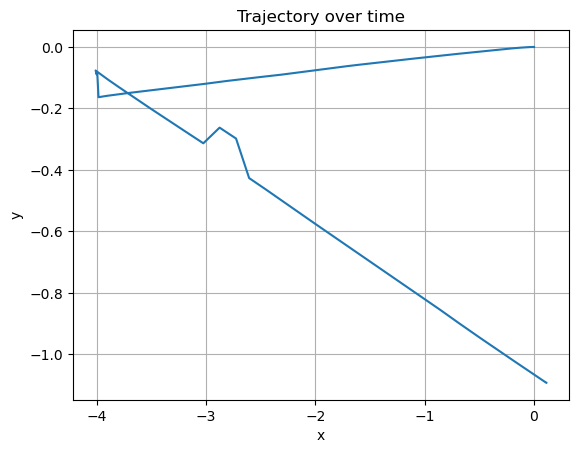

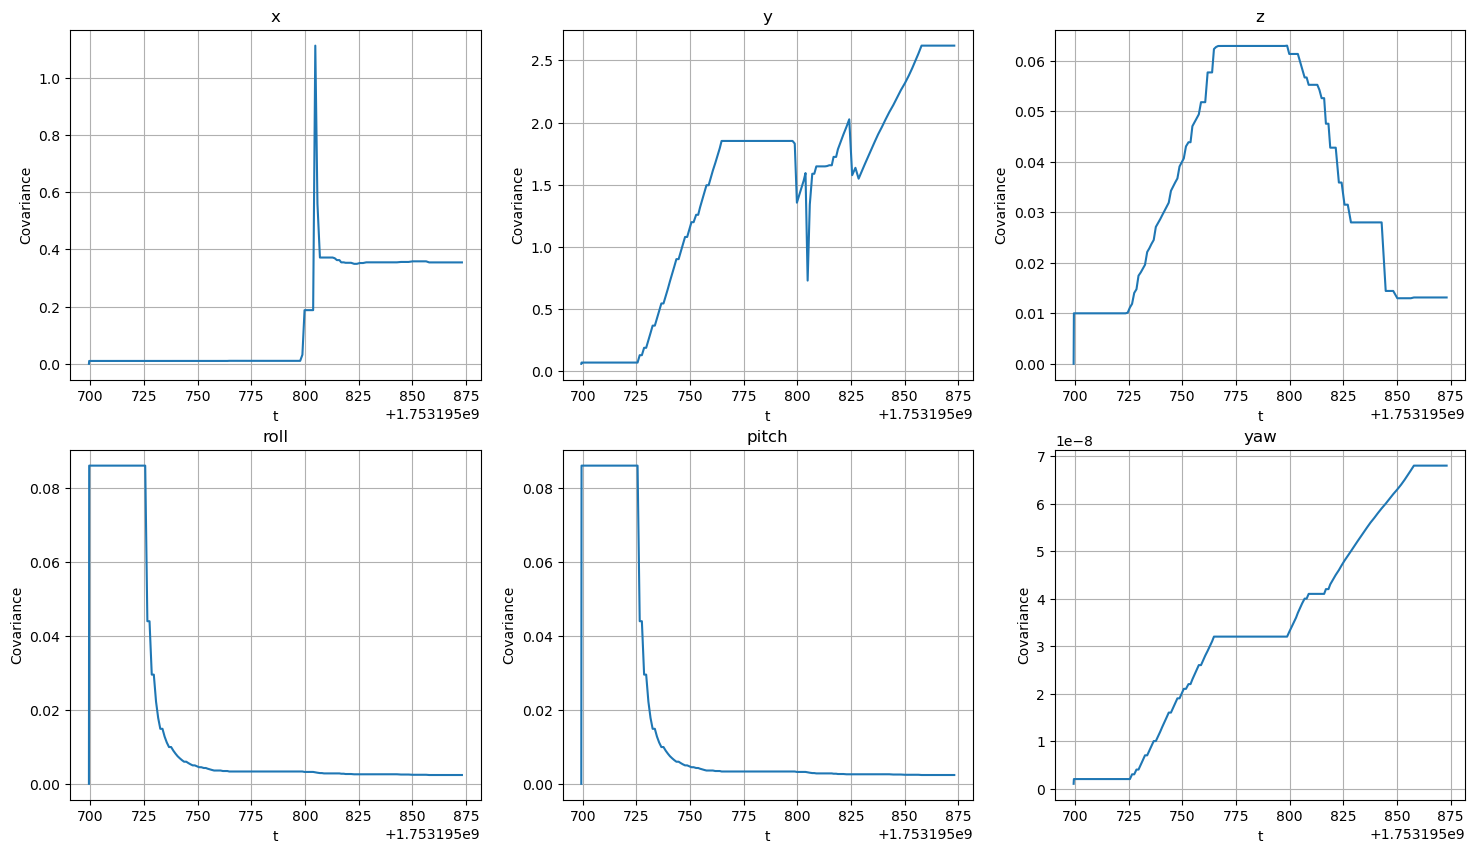

In [39]:
"""
Camera -> RTAB
IMU -> Madgwick -> RTAB
Wheel odom -> EKF -> RTAB
"""

"""
Camera -> RTAB
Wheel odom -> EKF -> RTAB
"""

# RTAB Data
# with IMU
bag_path = Path('../../../datasets/odometry_data/monica_rtab_with_imu_ekf_no_imu2')

poses_data = analyze_data(bag_path, '/monica/localization_pose')

plot_trajectory(poses_data)

plot_covariances(poses_data)

Bag duration: 192.17 seconds
Message count: 5801


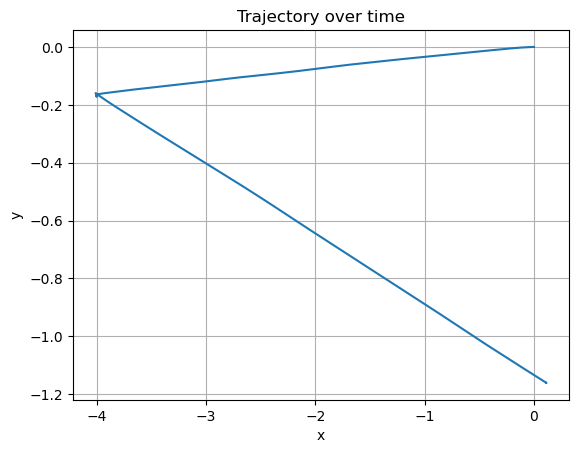

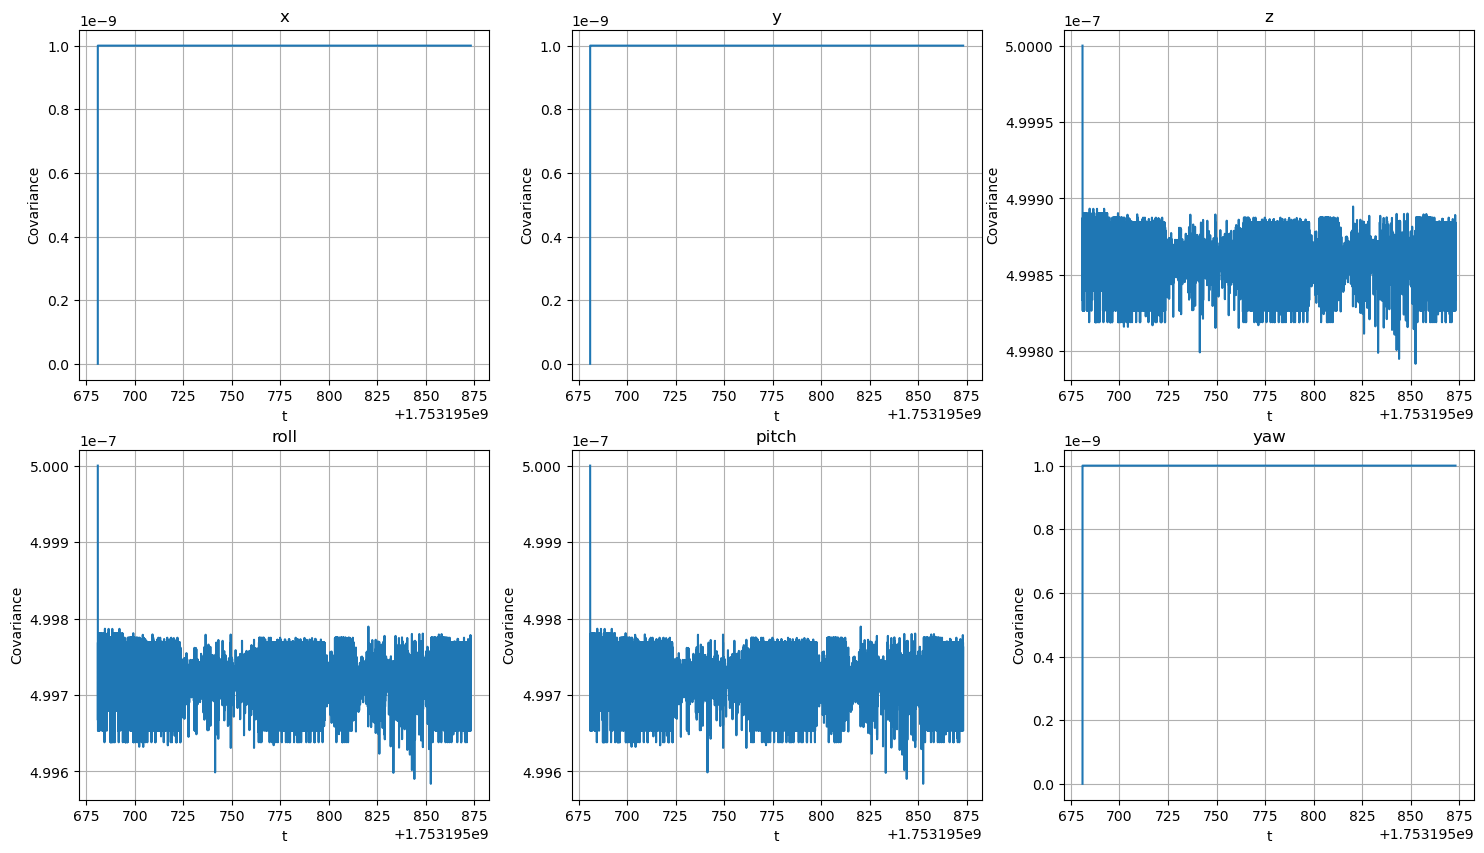

In [40]:
# EKF odometry output
ekf_data = analyze_data(bag_path, '/monica/odometry/filtered')

plot_trajectory(ekf_data)

plot_covariances(ekf_data)

# Experiments with Monica (Both receive IMU data)

Bag duration: 114.17 seconds
Message count: 3527


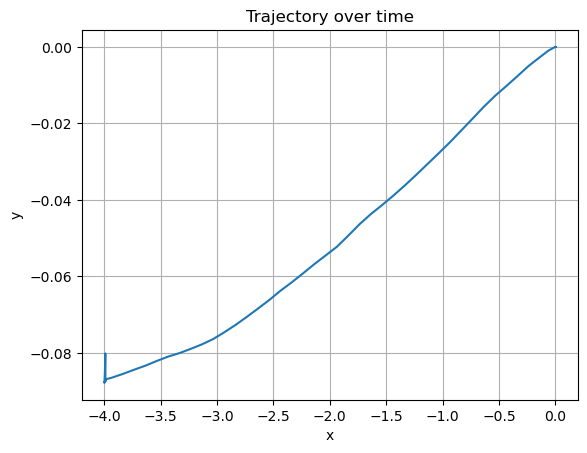

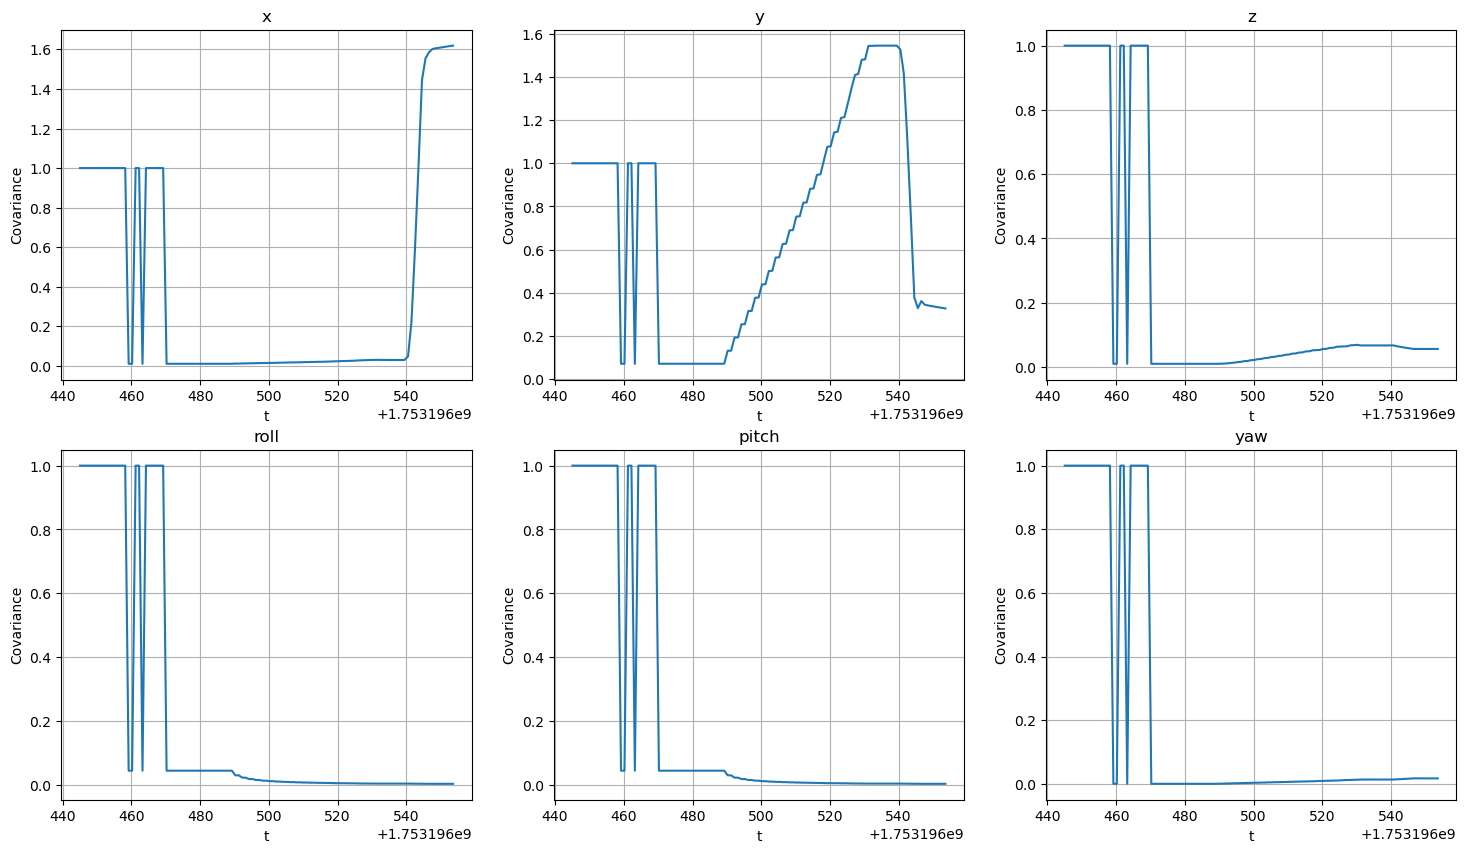

In [41]:
"""
Both with IMU data
Camera -> RTAB
IMU -> Madgwick -> RTAB
Wheel odom -> and IMU -> Madgwick -> EKF -> RTAB
"""

# RTAB Data
# with IMU
bag_path = Path(
    '../../../datasets/odometry_data/monica_rtab_ekf_both_with_imu2')

poses_data = analyze_data(bag_path, '/monica/localization_pose')

plot_trajectory(poses_data)

plot_covariances(poses_data)

Bag duration: 114.17 seconds
Message count: 3527


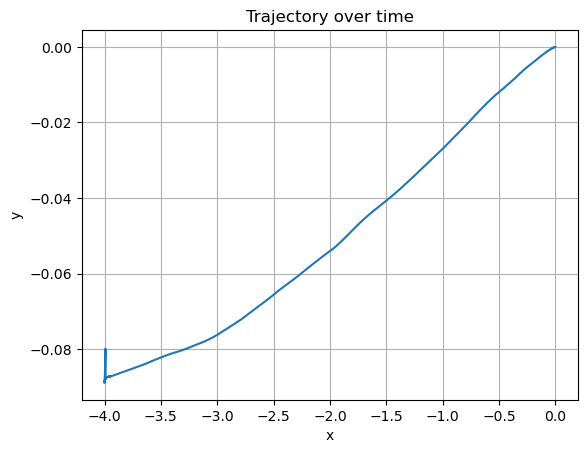

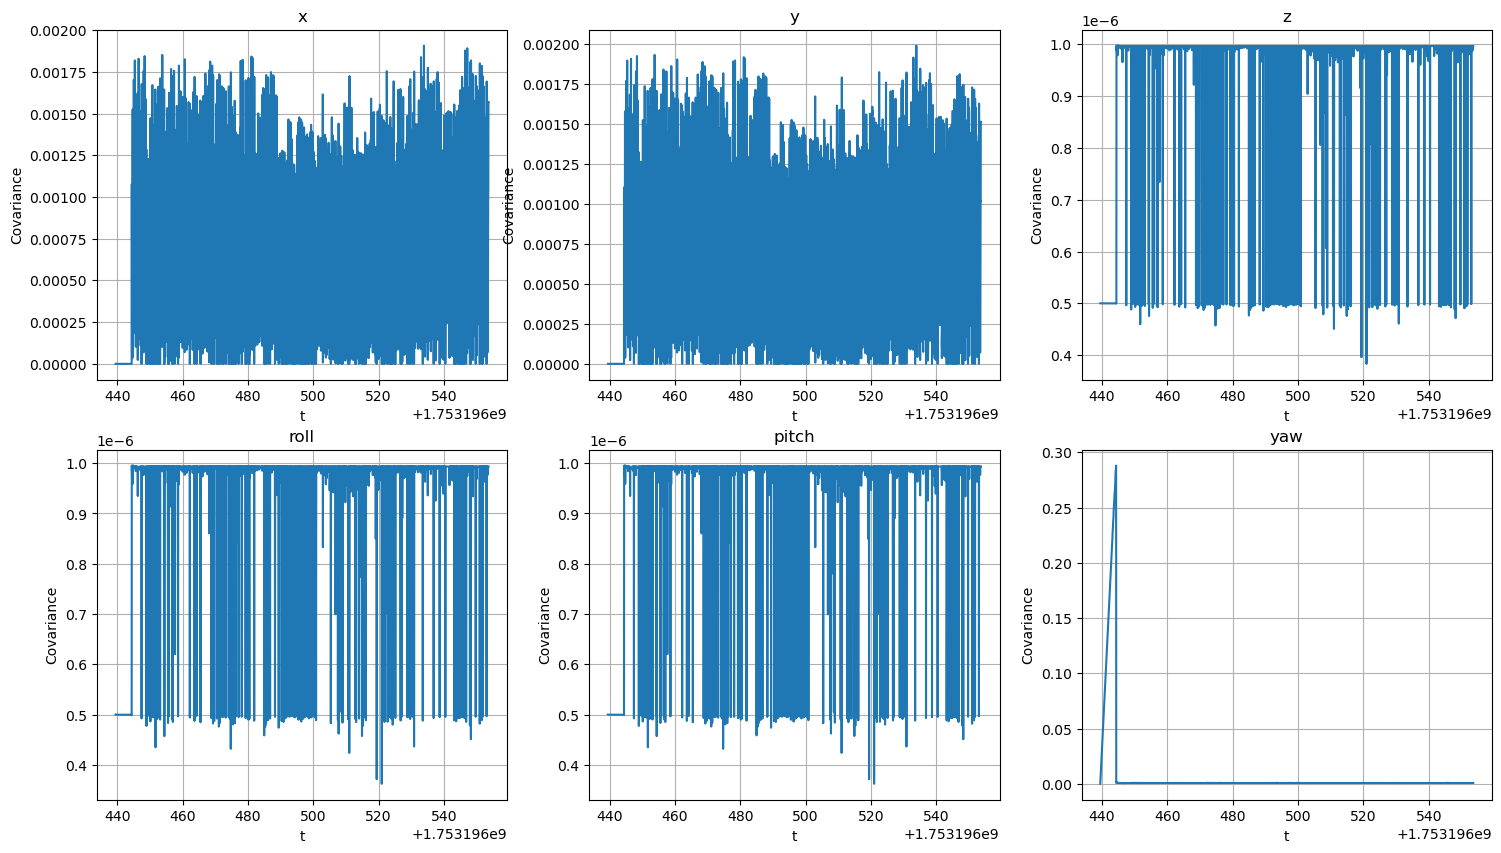

In [42]:
# EKF odometry output
ekf_data = analyze_data(bag_path, '/monica/odometry/filtered')

plot_trajectory(ekf_data)

plot_covariances(ekf_data)